In [1]:
import checklist
from checklist.editor import Editor
from checklist.perturb import Perturb

Before we create any tests, it's worth taking a tour of CheckList's abstractions for manipulating text data and coming up with examples. In this tutorial, we'll look at creating examples from scratch.

## Creating examples from scratch

### Templates

First, we'll create an editor:

In [2]:
editor = Editor()

The editor allows us to fill in templates with lists of 'fill-ins', and doing cartesian products. For example:

In [3]:
ret = editor.template('This is a {adj} movie.', adj=['good', 'great', 'awesome', 'excellent'])
ret.data

['This is a good movie.',
 'This is a great movie.',
 'This is a awesome movie.',
 'This is a excellent movie.']

`editor.template` returns a Munch (a glorified dict which allows us to call `ret.data` instead of `ret['data']`). 
If you set any of the arguments `labels`, `meta`, or `save`, additional fields will exist in `ret`. Here is an example, notice how `ret.labels` now has a label for each example in `ret.data`:

In [4]:
ret = editor.template('This is a {adj} movie.', adj=['good', 'great', 'awesome', 'excellent'], labels=1, meta=True, save=True)
ret.labels

[1, 1, 1, 1]

Setting `meta=True` gives us the fill in values for each example in `ret.data`:

In [5]:
print(ret.data[0], ret.meta[0])
print(ret.data[1], ret.meta[1])

This is a good movie. {'adj': 'good'}
This is a great movie. {'adj': 'great'}


Notice we had a bug before: 'This is a excellent movie' is not gramatically correct. Since this is a common ocurrence, you can set an option in the template to use the right article before a fill-in:

In [6]:
ret = editor.template('This is {a:adj} movie.', adj=['good', 'great', 'awesome', 'excellent'])
ret.data

['This is a good movie.',
 'This is a great movie.',
 'This is an awesome movie.',
 'This is an excellent movie.']

Now, the first argument does not need to be a single string. It can be a list, a tuple, or a dict. The same is true of the `labels` parameter:

In [7]:
ret = editor.template({'question': 'Is this a {adj} movie?',
                       'context': 'This is a {adj} movie.' },
                      labels='Yes, this is {adj}.',
                      adj=['good', 'great', 'awesome', 'excellent'])
print(ret.data[0])
print(ret.labels[0])
print()
print(ret.data[1])
print(ret.labels[1])
print()

{'question': 'Is this a good movie?', 'context': 'This is a good movie.'}
Yes, this is good.

{'question': 'Is this a great movie?', 'context': 'This is a great movie.'}
Yes, this is great.



### Lexicons

The editor has built-in lexicons, which you can use in templates without having to specify the fill-in values.

In [8]:
print(list(editor.lexicons.keys()))

['male', 'female', 'first_name', 'first_pronoun', 'last_name', 'country', 'nationality', 'city', 'religion', 'religion_adj', 'sexual_adj']


In [9]:
ret = editor.template('{male} is not friends with {female}')
ret.data[0:4]

['Michael is not friends with Jennifer',
 'Christopher is not friends with Jennifer',
 'Matthew is not friends with Jennifer',
 'David is not friends with Jennifer']

You can also use different versions of the same tag in a template by adding an integer to the end, e.g.:

In [10]:
ret = editor.template('{male1} is not friends with {male2}')
ret.data[0:4]

['Michael is not friends with Michael',
 'Christopher is not friends with Michael',
 'Matthew is not friends with Michael',
 'David is not friends with Michael']

If you set `remove_duplicates` to True, you will never get two fill-ins with the same value within an example:

In [11]:
ret = editor.template('{male1} is not friends with {male2}', remove_duplicates=True)
ret.data[0:4]

['Christopher is not friends with Michael',
 'Matthew is not friends with Michael',
 'David is not friends with Michael',
 'James is not friends with Michael']

You can also use different versions for tags that are not in the lexicons:

In [12]:
ret = editor.template('{adj1} is not the same as {adj2}', adj=['good', 'bad', 'great'], remove_duplicates=True)
ret.data[0:4]

['good is not the same as bad',
 'good is not the same as great',
 'bad is not the same as good',
 'bad is not the same as great']

Finally, you can also add tags to the lexicons and reuse them later:

In [13]:
editor.add_lexicon('adj', ['good', 'bad', 'great', 'terrible'])

In [14]:
ret = editor.template('{adj} is not the same as {adj2}', remove_duplicates=True)
ret.data[:4]

['good is not the same as bad',
 'good is not the same as great',
 'good is not the same as terrible',
 'bad is not the same as good']

### Masked Language Model Suggestion

You can use a masked language model to fill-in templates directly by using the special tag `{mask}`:

In [15]:
ret = editor.template('This is a {adj} {mask}.', remove_duplicates=True)
ret.data[:5]

['This is a good idea.',
 'This is a good sign.',
 'This is a good thing.',
 'This is a good example.',
 'This is a good start.']

You can also add multiple masks to a single example:

In [16]:
ret = editor.template('This is a {adj} {mask} {mask}.', remove_duplicates=True)
ret.data[:5]

['This is a good history lesson.',
 'This is a good chess move.',
 'This is a good news story.',
 'This is a good programming language.',
 'This is a good data set.']

Of course, sometimes you want to filter out some of the language model suggestions. You can use `editor.suggest` to just get the suggested words or tuples:

In [17]:
editor.suggest('This is a {adj} {mask}.')[:5]

['idea', 'sign', 'thing', 'example', 'start']

In [18]:
editor.suggest('This is a {adj} {mask} {mask}.')[:5]

[('history', 'lesson'),
 ('chess', 'move'),
 ('news', 'story'),
 ('programming', 'language'),
 ('data', 'set')]

Finally, you can use a very handy visualization to select suggestions from a list.
In the example below, we select only positive adjectives.  
(We use a gif here for the notebook to work in preview mode)

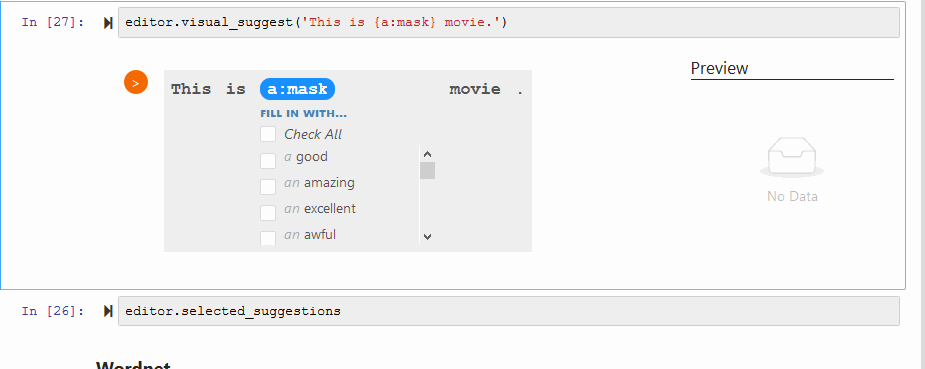

In [31]:
from IPython.display import HTML, Image
with open('visual_suggest.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

In [32]:
# editor.visual_suggest('This is {a:mask} movie.')

In [28]:
editor.selected_suggestions

['good',
 'amazing',
 'excellent',
 'interesting',
 'awesome',
 'incredible',
 'great',
 'enjoyable']

### Wordnet

You can also ask for suggestions based on wordnet categories (synonyms, antonyms, hypernyms, hyponyms):

In [19]:
editor.synonyms('John is a good man.', 'good')

['serious']

In [20]:
editor.antonyms('John is a evil man.', 'evil')

['good', 'goodness']

In [27]:
editor.hypernyms('My dog eats other animals.', 'dog')

['animal', 'creature', 'food', 'beast', 'meat', 'mammal', 'person', 'organism']

In [30]:
editor.hyponyms('My animal eats other animals.', 'animal')[:5]

['dog', 'pet', 'bird', 'prey', 'baby']

In [35]:
# Hyponyms of hypernym
editor.related_words('My dog eats other animals.', 'dog')[:5]

['cat', 'animal', 'monkey', 'pet', 'elephant']

Notice that these are context specific:

In [36]:
editor.antonyms('John is good.', 'good')

['bad', 'evil', 'ill']

In [37]:
editor.antonyms('Mac and cheese is good.', 'good')

['bad']